## Neuroevolution of CNN architectures

### Must Remember Points:
**Output dimension = W-F+2P/S + 1 is needed to calculate the input to the Linear layer**  
**If the output size ends up with a decimal ending it is floored to the nearest integer (13.5 --> 13)**  
**CONV --> RELU --> Dropout is the normally followed configuration**  
**Dense --> RELU --> Dropout is the norm**

In [124]:
import torch 
import torchvision
from torchvision import datasets
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

In [88]:
num_workers = 0

batch_size = 50

transform = transforms.ToTensor()

In [85]:
train_dataset = datasets.MNIST(root='data',train=True,download=True,transform=transform)
test_dataset = datasets.MNIST(root='data',train=False,download=True,transform=transform)

In [92]:
trainloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,num_workers=num_workers)
testloader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,num_workers=num_workers)

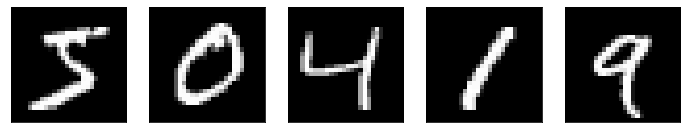

In [82]:
fig = plt.figure(figsize=(12,4))
for i in range(5):
    a = train_dataset[i]
    img = np.squeeze(a[0]) 
    ax = plt.subplot(1,5, i+1,xticks=[],yticks=[])
    ax.imshow(img, cmap='gray')

In [140]:
tr_images, tr_labels= next(iter(trainloader))
te_images, te_labels= next(iter(testloader))

print("Train loader batch - " + str(list(tr_images.shape)))
print("Train loader batches - " + str(len(trainloader)))
print("Test loader batch - " + str(list(te_images.shape)))
print("Test loader batches - " + str(len(testloader)))

Train loader batch - [50, 1, 28, 28]
Train loader batches - 1200
Test loader batch - [50, 1, 28, 28]
Test loader batches - 200


In [143]:
class CNN_Model(nn.Module):
    
    def __init__(self):
        
        super().__init__()
                                                    #------------>Input size = 28x28x1
        self.conv1 = nn.Conv2d(1,16,3,padding=1)    #------------>Output size = 28x28x16 (If continuous convolution 
        self.conv2 = nn.Conv2d(16,32,3,padding=1)   #------------>Output size = 28x28x32  operations without pooling
        #self.conv3 = nn.Conv2d(32,64,3,padding=1)   #------------>Output size = 28x28x64  then this would be the output size)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(7*7*32,500)            #------------>Input size = 7x7x32  
        self.output = nn.Linear(500,10)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self,x):
        
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        
        x = x.view(-1,7*7*32)
        
        x = self.dropout(torch.relu(self.fc1(x)))
        x = torch.log_softmax(self.output(x),dim=1)
            
        return x

In [152]:
network = CNN_Model()
optimizer = torch.optim.Adam(network.parameters(),lr=0.03)
criterion = nn.NLLLoss()

In [154]:
def train(model,optimizer,loss_fun,trainloader,testloader,epochs=10,device="cuda"):
    
    if torch.cuda.is_available:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    model.to(device)
    
    tr_list = []
    val_list = []
    acc_list = []
    epoch_list = [i+1 for i in range(epochs)]
    
    for epoch in range(epochs):
        
        training_loss = 0
        validation_loss = 0
        model.train()                #--------------------->Allows for parameters to be updated by backpropagation
        
        for batch in trainloader:
            
            optimizer.zero_grad()
            inputs,labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_fun(outputs,labels)
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
        
        model.eval()              #------------------------>Freezes the parameters for model validation
        correct_pred = 0
        total_pred = 0
        
        for batch in testloader:
            
            inputs,labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_fun(outputs,labels)
            
            validation_loss +=loss.item()
            
            ps = torch.exp(outputs)         #-------------->The final activation function is Log_Softmax that's why we take exp
            
            correct = torch.eq(torch.max(ps,dim=1)[1],labels).view(-1)
            
            correct_pred += torch.sum(correct).item()
            total_pred += correct.shape[0]       #--------->Alternatively can also write batch.shape[0]
            
        training_loss = training_loss/len(trainloader)
        validation_loss = validation_loss/len(testloader)
        
        tr_list.append(training_loss)
        val_list.append(validation_loss)
        acc_list.append((correct_pred*100.0/total_pred))
            
        print("Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}"
              .format(epoch+1, training_loss,validation_loss, correct_pred * 100.0 / total_pred))
    
    fig = plt.figure(figsize=(20,6))
        
    plt.subplot(1,3,1)
    plt.plot(epoch_list,tr_list)
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    
    plt.subplot(1,3,2)
    plt.plot(epoch_list,val_list)
    plt.title("Validation Loss")
    plt.xlabel("Epochs")
    
    plt.subplot(1,3,3)
    plt.plot(epoch_list,acc_list)
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    
    plt.show()

Epoch: 1, Training Loss: 0.36, Validation Loss: 0.33, accuracy = 92.76
Epoch: 2, Training Loss: 0.35, Validation Loss: 0.32, accuracy = 92.52
Epoch: 3, Training Loss: 0.38, Validation Loss: 0.30, accuracy = 92.49
Epoch: 4, Training Loss: 0.34, Validation Loss: 0.24, accuracy = 93.41
Epoch: 5, Training Loss: 0.36, Validation Loss: 0.37, accuracy = 91.45
Epoch: 6, Training Loss: 0.38, Validation Loss: 0.33, accuracy = 92.96
Epoch: 7, Training Loss: 0.36, Validation Loss: 0.36, accuracy = 90.28
Epoch: 8, Training Loss: 0.37, Validation Loss: 0.29, accuracy = 92.99
Epoch: 9, Training Loss: 0.36, Validation Loss: 0.47, accuracy = 91.58
Epoch: 10, Training Loss: 0.36, Validation Loss: 0.25, accuracy = 93.55


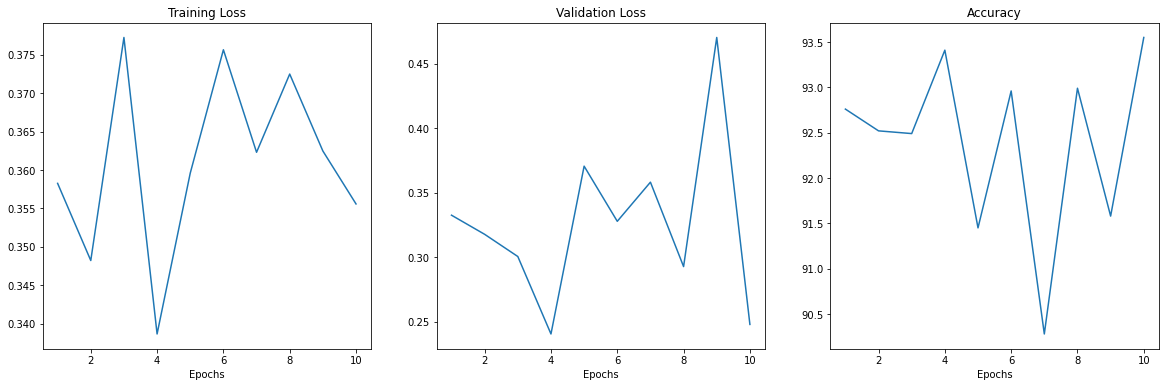

In [155]:
train(network,optimizer,criterion,trainloader,testloader)